In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

# from scipy.stats import spearmanr, pearsonr, zscore, iqr, sem
# from scipy.stats import pearsonr, spearmanr, norm, sem
import scipy.stats as st
from scipy.linalg import lstsq
from sklearn.preprocessing import minmax_scale

# spectrome imports:
from spectrome.brain import Brain
from spectrome.utils import functions, path, generate
from spectrome.forward import eigenmode, laplacian

Cumulative eigenmode spatial correlations
---

### 1. Set-up
We are going to just load the data first:

In [2]:
## Normal house-keeping:
data_dir = "../data"

# Load Pablo's Yeo 2017 canonical network maps
# fc_dk = np.load("../data/com_dk.npy", allow_pickle=True).item()
fc_dk_normalized = pd.read_csv("../data/DK_dictionary_normalized.csv").set_index(
    "Unnamed: 0"
)

# define list of canonical network names and re-order the dictionary using these names:
fc_names = [
    "Limbic",
    "Default",
    "Visual",
    "Fronto \n parietal",
    "Somato \n motor",
    "Dorsal \n Attention",
    "Ventral \n Attention",
]

fc_dk_normalized = fc_dk_normalized.reindex(
    [
        "Limbic",
        "Default",
        "Visual",
        "Frontoparietal",
        "Somatomotor",
        "Dorsal_Attention",
        "Ventral_Attention",
    ]
).fillna(0)

K = 30  # number of eigenmodes

opt_param = np.zeros([len(fc_names), 2])

## Load the optimized parameters first
h5_path = os.path.join(data_dir, "default_pearson.h5")
bh_default = path.read_hdf5(h5_path)
opt_param[1, :] = bh_default["x"]
# print('Default network parameters:' + str(np.round(bh_default['x'],2)))

h5_path = os.path.join(data_dir, "dorsal_pearson.h5")
bh_dorsal = path.read_hdf5(h5_path)
opt_param[5, :] = bh_dorsal["x"]
# print('Doral Attention network parameters:' + str(np.round(bh_dorsal['x'],2)))

h5_path = os.path.join(data_dir, "fronto_pearson.h5")
bh_front = path.read_hdf5(h5_path)
opt_param[3, :] = bh_front["x"]
# print('Frontoparietal network parameters:' + str(np.round(bh_front['x'],2)))

h5_path = os.path.join(data_dir, "limbic_pearson.h5")
bh_limbic = path.read_hdf5(h5_path)
opt_param[0, :] = bh_limbic["x"]
# print('Limbic network parameters:' + str(np.round(bh_limbic['x'],2)))

h5_path = os.path.join(data_dir, "motor_pearson.h5")
bh_motor = path.read_hdf5(h5_path)
opt_param[4, :] = bh_motor["x"]
# print('Somatomotor network parameters:' + str(np.round(bh_motor['x'],2)))

h5_path = os.path.join(data_dir, "ventral_pearson.h5")
bh_ventral = path.read_hdf5(h5_path)
opt_param[6, :] = bh_ventral["x"]
# print('Ventral Attention network parameters:' + str(np.round(bh_ventral['x'],2)))

h5_path = os.path.join(data_dir, "visual_pearson.h5")
bh_visual = path.read_hdf5(h5_path)
opt_param[2, :] = bh_visual["x"]
# print('Visual network parameters:' + str(np.round(bh_visual['x'],2)))

# pile these parameters:
parameters = pd.DataFrame(
    data=opt_param, index=fc_dk_normalized.index, columns=["alpha", "wave_number"]
)
print(parameters)

                      alpha  wave_number
Unnamed: 0                              
Limbic             2.985749   102.203441
Default            2.836397    30.476174
Visual             2.387136   154.917185
Frontoparietal     2.741911     6.842158
Somatomotor        0.284209     2.605243
Dorsal_Attention   0.849410    47.690187
Ventral_Attention  2.732136     5.532311


### 1.1 - Testing

Let's compute the complex Laplacian eigenmodes next, using the visual network as an example.

In [3]:
# create brain object and load in SC:
brain = Brain.Brain()
brain.add_connectome(data_dir)
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()

# eigenmode decomposition
brain.decompose_complex_laplacian(
    alpha=parameters.loc["Limbic", "alpha"],
    k=parameters.loc["Limbic", "wave_number"],
    vis=False,
)
print(brain.norm_eigenmodes.shape)

(86, 86)


Now let's computet the Pearson's correlation for all eigenmodes and sort them by best spatial correlation to the visual system to lowest spatial match:

Text(0, 0.5, 'Pearson R')

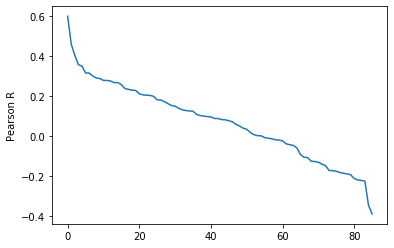

In [4]:
# First, pre-allocate an array for spatial correlations:
corrs = np.squeeze(np.zeros([len(brain.norm_eigenmodes), 1]))
# Define the visual network, remove the NaNs:
limbic_network = np.nan_to_num(fc_dk_normalized.loc["Limbic"].values)

# compute the spatial correlations:
for e in np.arange(0, len(corrs)):
    corrs[e] = st.pearsonr(np.squeeze(limbic_network), brain.norm_eigenmodes[:, e])[0]

# sort the eigenmodes:
ordered_eigenmodes = np.argsort(-np.round(corrs, 3))

# visualize the sorted pearson's R first as a sanity check:
plt.plot(corrs[ordered_eigenmodes])
plt.ylabel("Pearson R")

OK, the Pearson's correlation is indeed steadily decreasing after sorting. 

The next step is to cumulatively add up these eigenmodes and use linear least square weights to look at their spatial match.

In [5]:
print('The best performing eigenmode is number {} and it has a spatial correlation of {:.2f}.'.format(ordered_eigenmodes[0], corrs[ordered_eigenmodes[0]]))

The best performing eigenmode is number 26 and it has a spatial correlation of 0.60.


In [6]:
# Let's see what happens when we cumulatively combine 2 eigenmodes:
coef, _, _, _ = lstsq(
    brain.norm_eigenmodes[:, ordered_eigenmodes[0:2]],
    fc_dk_normalized.loc["Limbic"].values,
    lapack_driver="gelsy",
)
print("The coefficients for the first two eigenmodes are: {}".format(np.round(coef, 2)))

# Now we compute the spatial correlatiton after combining:
comb = brain.norm_eigenmodes[:, ordered_eigenmodes[0:2]] @ coef
new_pearson = st.pearsonr(
    np.squeeze(fc_dk_normalized.loc["Limbic"].values), np.squeeze(comb)
)[0]
print("The new spatial correlation is: {:.2f}".format(new_pearson))

The coefficients for the first two eigenmodes are: [0.71 0.16]
The new spatial correlation is: 0.62


The spatial correlation increases with 2 eigenmodes combined... but there are sudden decreases, let's examine what is going on:

3 is smallar than 2
5 is smallar than 4
10 is smallar than 9
13 is smallar than 12
23 is smallar than 22
46 is smallar than 45


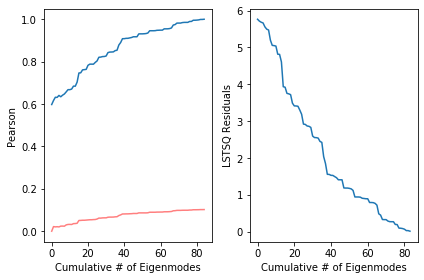

In [7]:
all_r = np.zeros([85, 1])
all_r[0] = corrs[ordered_eigenmodes[0]]
residuals = np.zeros([84, 1])
variances = np.zeros([85, 1])

for k in np.arange(1, 85):
    selected_eigs = brain.norm_eigenmodes[:, ordered_eigenmodes[0 : k + 1]]
    coef, res, _, _ = np.linalg.lstsq(selected_eigs, limbic_network, rcond=None)
    comb = selected_eigs @ coef
    variances[k] = np.var(comb)
    all_r[k] = st.pearsonr(limbic_network, comb)[0]
    residuals[k - 1] = np.squeeze(res)
    if all_r[k] < all_r[k - 1]:
        print("{} is smallar than {}".format(k, k - 1))

fig, ax = plt.subplots(1, 2)
ax[0].plot(all_r)
ax[0].set_ylabel("Pearson")
ax[0].plot(variances, color="red", alpha=0.5)
ax[0].set_xlabel("Cumulative # of Eigenmodes")
ax[1].plot(residuals)
ax[1].set_ylabel("LSTSQ Residuals")
ax[1].set_xlabel("Cumulative # of Eigenmodes")

plt.tight_layout()

Run the same but with real-value Laplacian:

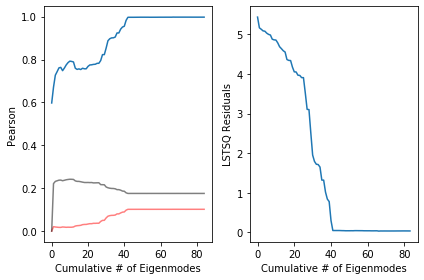

In [8]:
brain.decompose_regular_laplacian(alpha=parameters.loc["Limbic", "alpha"])

# compute the spatial correlations:
for e in np.arange(0, len(corrs)):
    corrs[e] = st.pearsonr(np.squeeze(limbic_network), brain.norm_eigenmodes[:, e])[0]

# sort the eigenmodes:
ordered_eigenmodes = np.argsort(-np.round(corrs, 3))

all_r = np.zeros([85, 1])
all_r[0] = corrs[ordered_eigenmodes[0]]
residuals = np.zeros([84, 1])
comb_means = np.zeros([85, 1])
variances = np.zeros([85, 1])

for k in np.arange(1, 85):
    selected_eigs = brain.norm_eigenmodes[:, ordered_eigenmodes[0 : k + 1]]
    coef, res, _, _ = np.linalg.lstsq(selected_eigs, limbic_network, rcond=None)
    comb = selected_eigs @ coef
    comb_means[k] = np.mean(comb)
    variances[k] = np.var(comb)
    all_r[k] = st.pearsonr(limbic_network, comb)[0]
    dp = np.linalg.norm(limbic_network - (selected_eigs @ coef), 2) ** 2
    residuals[k - 1] = dp
    # if all_r[k] < all_r[k-1]:
    # print('{} is smallar than {}'.format(k, k-1))

fig, ax = plt.subplots(1, 2)
ax[0].plot(all_r)
ax[0].set_ylabel("Pearson")
ax[0].plot(variances, color="red", alpha=0.5)
ax[0].plot(comb_means, color="black", alpha=0.5)
ax[0].set_xlabel("Cumulative # of Eigenmodes")
ax[1].plot(residuals)
ax[1].set_ylabel("LSTSQ Residuals")
ax[1].set_xlabel("Cumulative # of Eigenmodes")

plt.tight_layout()

### 2 - For all networks:
The Pearson's correlation is not a good metric of linear least squares residuals. Perhaps it's better to show both correlation and residual in the figure. Let's compute Pearson's and residuals for a given canonical functional network with the following: 

In [9]:
# consolidate the computations above into a function with inputs:
def compute_lstsq(fnetworks, a, wnk, fc_name, corr_type="pearson", lap_type="complex"):
    # initiate a brain with template HCP connectome
    brain = Brain.Brain()
    brain.add_connectome(data_dir)
    brain.reorder_connectome(brain.connectome, brain.distance_matrix)
    brain.bi_symmetric_c()
    brain.reduce_extreme_dir()

    # obtain structural eigenmodes
    if lap_type == "complex":
        brain.decompose_complex_laplacian(alpha=a, k=wnk, vis=False)
    elif lap_type == "regular":
        brain.decompose_regular_laplacian(alpha=a)
    elif lap_type == "distance":
        CUD = generate.random_Cij_und(86, 86)
        CUD = generate.add_weights(
            CUD, np.mean(brain.distance_matrix), np.std(brain.distance_matrix)
        )
        brain.distance_matrix = CUD
        brain.decompose_complex_laplacian(alpha=a, k=wnk, vis=False)
    elif lap_type == "random":
        randD = np.random.uniform(
            low=np.amin(brain.distance_matrix),
            high=np.amax(brain.distance_matrix),
            size=brain.reducedConnectome.shape,
        )
        brain.reducedConnectome = generate.exp_neg_dist_Cij(randD)
        brain.distance_matrtix = generate.distance_matrix(
            brain.reducedConnectome, randD
        )
        brain.decompose_complex_laplacian(alpha=a, k=wnk, vis=False)
    elif lap_type == "full":
        brain.decompose_complex_laplacian(alpha=a, k=wnk, vis=False, take_abs=False)

    # compute the spatial correlation:
    corrs = np.squeeze(np.zeros([86, 1]))
    canonical_network = np.nan_to_num(fnetworks.loc[fc_name].values)
    for v in np.arange(0, len(corrs)):
        if corr_type == "pearson":
            corrs[v] = st.pearsonr(
                np.squeeze(canonical_network), brain.norm_eigenmodes[:, v]
            )[0]
        elif corr_type == "spearman":
            corrs[v] = st.spearmanr(
                np.squeeze(canonical_network), brain.norm_eigenmodes[:, v]
            )[0]

    # sorting eigenmodes by spatial correlation:
    ordered_eigenmodes = np.argsort(-np.round(corrs, 3))

    # cumulatively combine eigenmodes and get combined spatial correlation and residuals:
    all_corr = np.zeros([85, 1])
    all_corr[0] = corrs[ordered_eigenmodes[0]]  # the first eigenmode by itself
    residuals = np.zeros(
        [84, 1]
    )  # ignoring 1st eigenmode by itself and full set of eigenmode
    for k in np.arange(1, 85):
        selected_eigs = brain.norm_eigenmodes[:, ordered_eigenmodes[0 : k + 1]]
        # coef,res,rank,_ = np.linalg.lstsq(selected_eigs, canonical_network, rcond=None)
        coef, res, rank, _ = lstsq(
            selected_eigs, canonical_network, lapack_driver="gelsy"
        )
        comb = selected_eigs @ coef
        if corr_type == "pearson":
            all_corr[k] = st.pearsonr(canonical_network, comb)[0]
        elif corr_type == "spearman":
            all_corr[k] = st.spearman(canonical_network, comb)[0]
        # print('rank is {} and number of eigenmodes is {}'.format(rank,selected_eigs.shape[1]))
        # compute residual:
        dp = np.linalg.norm(canonical_network - (selected_eigs @ coef), 2) ** 2
        residuals[k - 1] = dp

    return np.squeeze(all_corr), np.squeeze(residuals)

Run this function for all canonical network comparisons:

In [10]:
complex_residuals = np.zeros([84, 7])  # combinations of eigenmodes and 7 networks
complex_pearsonr = np.zeros([85, 7])  # combinations of eigenmodes and 7 networks

for i in np.arange(0, len(fc_names)):
    # for each of the 7 canonical networks:
    complex_pearsonr[:, i], complex_residuals[:, i] = compute_lstsq(
        fc_dk_normalized,
        a=parameters.iloc[i, 0],
        wnk=parameters.iloc[i, 1],
        fc_name=fc_dk_normalized.index[i],
    )

### 2.1 - Visualize:
Let's see if this for-loop produced the right results, we will keep adding onto these plots:

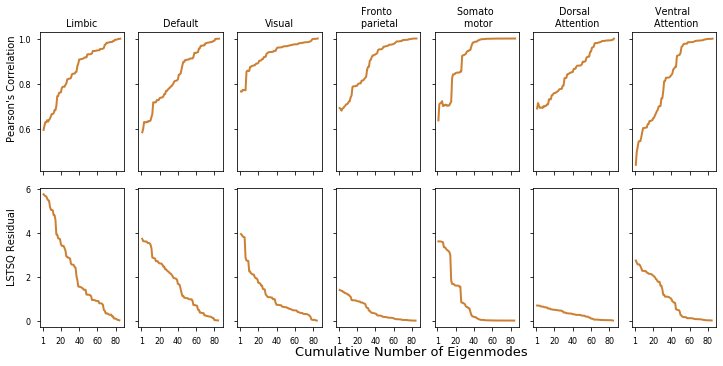

In [11]:
LW = 2  # line width for matplotlib

with plt.style.context("seaborn-paper"):
    corr_fig, corr_ax = plt.subplots(2, 7, figsize=(10, 5), sharey="row", sharex=True)
    for i, ax in enumerate(corr_ax.reshape(-1)):
        if i <= 6:
            ax.plot(
                np.arange(1, 86),
                complex_pearsonr[:, i],
                color=(0.8, 0.5, 0.2),
                linewidth=LW,
            )
            ax.title.set_text(fc_names[i])
        if i > 6:
            ax.plot(
                np.arange(1, 85),
                complex_residuals[:, i - 7],
                color=(0.8, 0.5, 0.2),
                linewidth=LW,
            )
            ax.xaxis.set_major_locator(plt.MultipleLocator(20))
            ax.set_xticklabels([0, 1, 20, 40, 60, 80])

    plt.tight_layout()
    corr_fig.text(0.00, 0.60, "Pearson's Correlation", fontsize=10, rotation="vertical")
    corr_fig.text(0.00, 0.20, "LSTSQ Residual", fontsize=10, rotation="vertical")
    corr_fig.text(0.40, 0.00, "Cumulative Number of Eigenmodes", fontsize=13)

### 2.2 Real-Valued Laplacians:

Now we do the same for the real-valued Laplacian:

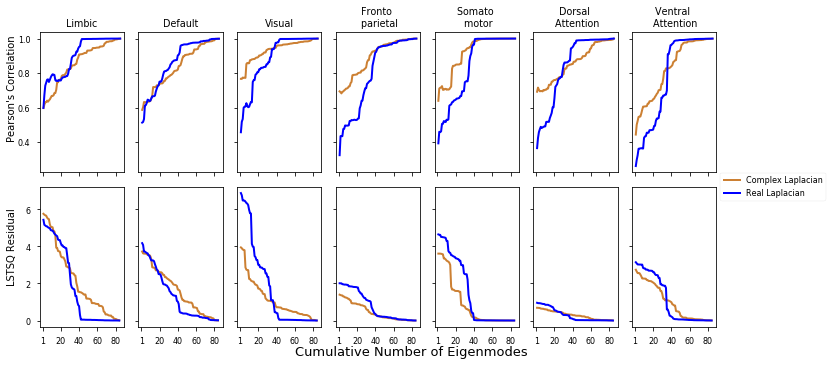

In [12]:
real_residual = np.zeros([84, 7])
real_pearsonr = np.zeros([85, 7])

for i in np.arange(0, len(fc_names)):
    # for each of the 7 canonical networks:
    real_pearsonr[:, i], real_residual[:, i] = compute_lstsq(
        fc_dk_normalized,
        a=parameters.iloc[i, 0],
        wnk=parameters.iloc[i, 1],
        fc_name=fc_dk_normalized.index[i],
        lap_type="regular",
    )

# add-onto the plot above:
with plt.style.context("seaborn-paper"):
    corr_fig, corr_ax = plt.subplots(2, 7, figsize=(10, 5), sharey="row", sharex=True)
    for i, ax in enumerate(corr_ax.reshape(-1)):
        if i <= 6:
            ax.plot(
                np.arange(1, 86),
                complex_pearsonr[:, i],
                color=(0.8, 0.5, 0.2),
                linewidth=LW,
            )
            ax.plot(np.arange(1, 86), real_pearsonr[:, i], color="blue", linewidth=LW)
            ax.title.set_text(fc_names[i])
        if i > 6:
            ax.plot(
                np.arange(1, 85),
                complex_residuals[:, i - 7],
                color=(0.8, 0.5, 0.2),
                linewidth=LW,
            )
            ax.plot(
                np.arange(1, 85), real_residual[:, i - 7], color="blue", linewidth=LW
            )
            ax.xaxis.set_major_locator(plt.MultipleLocator(20))
            ax.set_xticklabels([0, 1, 20, 40, 60, 80])

    plt.tight_layout()
    corr_fig.text(0.00, 0.60, "Pearson's Correlation", fontsize=10, rotation="vertical")
    corr_fig.text(0.00, 0.20, "LSTSQ Residual", fontsize=10, rotation="vertical")
    corr_fig.text(0.40, 0.00, "Cumulative Number of Eigenmodes", fontsize=13)
    plt.legend(
        ["Complex Laplacian", "Real Laplacian"],
        loc="center left",
        bbox_to_anchor=(1, 1),
    )

### 2.3 - Random $C_{ij}$ and $D_{ij}$ 

Now we run 1000 simulations of random matrices:

In [ ]:
from tqdm.notebook import tqdm

rng_runs = 1000 # 1000 random simulations
np.random.seed(24) # set-up seed for RNG
pearsonr_shape = [85, rng_runs]
residual_shape = [84, rng_runs]

# pre-allocate arrays to save results
limbic_pearsonr = np.zeros(pearsonr_shape)
limbic_residual = np.zeros(residual_shape)
default_pearsonr = np.zeros(pearsonr_shape)
default_residual = np.zeros(residual_shape)
visual_pearsonr = np.zeros(pearsonr_shape)
visual_residual = np.zeros(residual_shape)
front_pearsonr = np.zeros(pearsonr_shape)
front_residual = np.zeros(residual_shape)
motor_pearsonr = np.zeros(pearsonr_shape)
motor_residual = np.zeros(residual_shape)
ventral_pearsonr = np.zeros(pearsonr_shape)
ventral_residual = np.zeros(residual_shape)
dorsal_pearsonr = np.zeros(pearsonr_shape)
dorsal_residual = np.zeros(residual_shape)

for r in tqdm(np.arange(0, rng_runs), desc='random random matrix'):
    limbic_pearsonr[:,r], limbic_residual[:,r]=compute_lstsq(
        fc_dk_normalized,
        a=bh_limbic['x'][0],
        wnk=bh_limbic['x'][1],
        fc_name='Limbic',
        lap_type='random',
    )
    
    default_pearsonr[:,r], default_residual[:,r]=compute_lstsq(
        fc_dk_normalized,
        a=bh_default['x'][0],
        wnk=bh_default['x'][1],
        fc_name='Default',
        lap_type='random',
    )
    
    visual_pearsonr[:,r], visual_residual[:,r]=compute_lstsq(
        fc_dk_normalized,
        a=bh_visual['x'][0],
        wnk=bh_visual['x'][1],
        fc_name='Visual',
        lap_type='random',
    )
    
    front_pearsonr[:, r], front_residual[:,r] = compute_lstsq(
        fc_dk_normalized,
        a=bh_front["x"][0],
        wnk=bh_front["x"][1],
        fc_name="Frontoparietal",
        lap_type="random",
    )
    
    motor_pearsonr[:, r], motor_residual[:, r] = compute_lstsq(
        fc_dk_normalized,
        a=bh_motor["x"][0],
        wnk=bh_motor["x"][1],
        fc_name="Somatomotor",
        lap_type="random",
    )

    dorsal_pearsonr[:, r], dorsal_residual[:, r] = compute_lstsq(
        fc_dk_normalized,
        a=bh_dorsal["x"][0],
        wnk=bh_dorsal["x"][1],
        fc_name="Dorsal_Attention",
        lap_type="random",
    )

    ventral_pearsonr[:, r], ventral_residual[:, r] = compute_lstsq(
        fc_dk_normalized,
        a=bh_ventral["x"][0],
        wnk=bh_ventral["x"][1],
        fc_name="Ventral_Attention",
        lap_type="random",
    )

In [ ]:
# save the intermediate results:
np.savez('../data/random_connectome.npz', limbic_residual = limbic_residual, limbic_pearsonr = limbic_pearsonr,
        default_residual = default_residual, default_pearsonr = default_pearsonr,
        visual_residual = visual_residual, visual_pearsonr = visual_pearsonr,
        front_residual = front_residual, front_pearsonr = front_pearsonr,
        motor_residual = motor_residual, motor_pearsonr = motor_pearsonr,
        dorsal_residual = dorsal_residual, dorsal_pearsonr = dorsal_pearsonr,
        ventral_residual = ventral_residual, ventral_pearsonr = ventral_pearsonr)

In [13]:
# load the results:
rand_dist = np.load("../data/random_connectome.npz")

### 2.4 - Z-score and confidence interval:

Compute 95% confidence interval for the random distance matrix outputs:

In [14]:
def get_errorbar(in_data):
    sample_mean = np.mean(in_data, axis=1)
    # n = 1000
    # zsamples = zscore(in_data, axis = 1)
    # z_lower = iqr(zsamples, axis=1, rng=(5,50))
    # z_upper = iqr(zsamples, axis=1, rng=(50,95))
    sample_sigma = st.sem(in_data, axis=1)
    sample_lower, sample_upper = st.norm.interval(
        0.95, loc=sample_mean, scale=sample_sigma
    )
    # sample_upper = sample_mean+(z_upper*sample_sigma)
    # sample_lower = sample_mean-(z_lower*sample_sigma)
    # return sample_mean, sample_mean-h, sample_mean+h
    return sample_mean, sample_lower, sample_upper

In [15]:
cf = 0.95  # confidence interval
upper_pr = np.zeros([7, 85])
lower_pr = np.zeros([7, 85])
upper_rr = np.zeros([7, 84])
lower_rr = np.zeros([7, 84])
pearsonr_mean = np.zeros([7, 85])
residual_mean = np.zeros([7, 84])

c = 0
r = 0
for i, keys in enumerate(rand_dist.keys()):
    if i & 1 == 1:
        pearsonr_mean[c, :], lower_pr[c, :], upper_pr[c, :] = get_errorbar(
            rand_dist[keys]
        )
        c += 1
    if i & 1 == 0:
        residual_mean[r, :], lower_rr[r, :], upper_rr[r, :] = get_errorbar(
            rand_dist[keys]
        )
        r += 1

### 2.5 - Visualize:

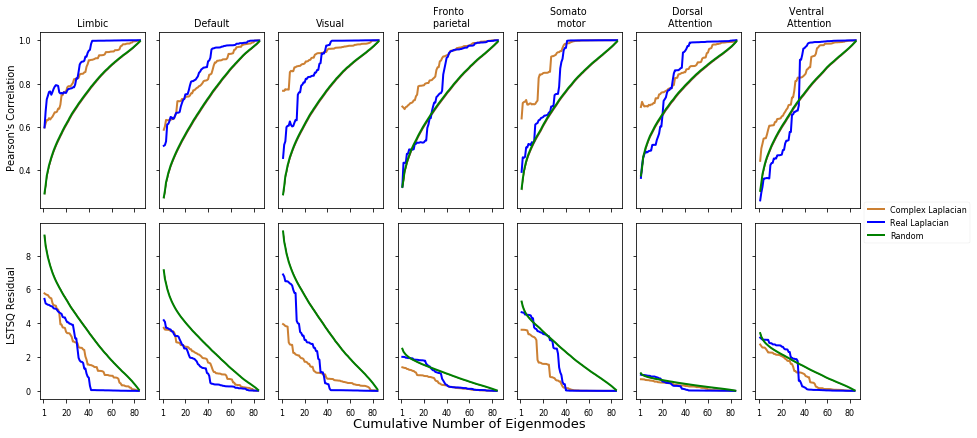

In [16]:
# add-onto the plot above:
with plt.style.context("seaborn-paper"):
    corr_fig, corr_ax = plt.subplots(2, 7, figsize=(12, 6), sharey="row", sharex=True)
    for i, ax in enumerate(corr_ax.reshape(-1)):
        if i <= 6:
            ax.plot(
                np.arange(1, 86),
                complex_pearsonr[:, i],
                color=(0.8, 0.5, 0.2),
                linewidth=LW,
            )
            ax.plot(np.arange(1, 86), real_pearsonr[:, i], color="blue", linewidth=LW)
            ax.plot(np.arange(1, 86), pearsonr_mean[i, :], color="green", linewidth=LW)
            ax.fill_between(
                np.arange(1, 86),
                lower_pr[i, :],
                upper_pr[i, :],
                color="maroon",
                alpha=0.8,
            )
            ax.title.set_text(fc_names[i])
        if i > 6:
            ax.plot(
                np.arange(1, 85),
                complex_residuals[:, i - 7],
                color=(0.8, 0.5, 0.2),
                linewidth=LW,
            )
            ax.plot(
                np.arange(1, 85), real_residual[:, i - 7], color="blue", linewidth=LW
            )
            ax.plot(
                np.arange(1, 85), residual_mean[i - 7, :], color="green", linewidth=LW
            )
            ax.fill_between(
                np.arange(1, 85),
                lower_rr[i - 7, :],
                upper_rr[i - 7, :],
                color="maroon",
                alpha=0.8,
            )
            ax.xaxis.set_major_locator(plt.MultipleLocator(20))
            ax.set_xticklabels([0, 1, 20, 40, 60, 80])

    plt.tight_layout()
    corr_fig.text(0.00, 0.60, "Pearson's Correlation", fontsize=10, rotation="vertical")
    corr_fig.text(0.00, 0.20, "LSTSQ Residual", fontsize=10, rotation="vertical")
    corr_fig.text(0.40, 0.00, "Cumulative Number of Eigenmodes", fontsize=13)
    plt.legend(
        ["Complex Laplacian", "Real Laplacian", "Random"],
        loc="center left",
        bbox_to_anchor=(1, 1),
    )

### 2.6 - Generate random distance matrices:

In [ ]:
rng_runs = 1000 # 1000 distance simulations
pearsonr_shape = [85, rng_runs]
residual_shape = [84, rng_runs]

# pre-allocate arrays to save results
limbic_pearsonr = np.zeros(pearsonr_shape)
limbic_residual = np.zeros(residual_shape)
default_pearsonr = np.zeros(pearsonr_shape)
default_residual = np.zeros(residual_shape)
visual_pearsonr = np.zeros(pearsonr_shape)
visual_residual = np.zeros(residual_shape)
front_pearsonr = np.zeros(pearsonr_shape)
front_residual = np.zeros(residual_shape)
motor_pearsonr = np.zeros(pearsonr_shape)
motor_residual = np.zeros(residual_shape)
ventral_pearsonr = np.zeros(pearsonr_shape)
ventral_residual = np.zeros(residual_shape)
dorsal_pearsonr = np.zeros(pearsonr_shape)
dorsal_residual = np.zeros(residual_shape)

for r in tqdm(np.arange(0, rng_runs), desc='distance distance matrix'):
    limbic_pearsonr[:,r], limbic_residual[:,r]=compute_lstsq(
        fc_dk_normalized,
        a=bh_limbic['x'][0],
        wnk=bh_limbic['x'][1],
        fc_name='Limbic',
        lap_type='distance',
    )
    
    default_pearsonr[:,r], default_residual[:,r]=compute_lstsq(
        fc_dk_normalized,
        a=bh_default['x'][0],
        wnk=bh_default['x'][1],
        fc_name='Default',
        lap_type='distance',
    )
    
    visual_pearsonr[:,r], visual_residual[:,r]=compute_lstsq(
        fc_dk_normalized,
        a=bh_visual['x'][0],
        wnk=bh_visual['x'][1],
        fc_name='Visual',
        lap_type='distance',
    )
    
    front_pearsonr[:, r], front_residual[:,r] = compute_lstsq(
        fc_dk_normalized,
        a=bh_front["x"][0],
        wnk=bh_front["x"][1],
        fc_name="Frontoparietal",
        lap_type="distance",
    )
    
    motor_pearsonr[:, r], motor_residual[:, r] = compute_lstsq(
        fc_dk_normalized,
        a=bh_motor["x"][0],
        wnk=bh_motor["x"][1],
        fc_name="Somatomotor",
        lap_type="distance",
    )

    dorsal_pearsonr[:, r], dorsal_residual[:, r] = compute_lstsq(
        fc_dk_normalized,
        a=bh_dorsal["x"][0],
        wnk=bh_dorsal["x"][1],
        fc_name="Dorsal_Attention",
        lap_type="distance",
    )

    ventral_pearsonr[:, r], ventral_residual[:, r] = compute_lstsq(
        fc_dk_normalized,
        a=bh_ventral["x"][0],
        wnk=bh_ventral["x"][1],
        fc_name="Ventral_Attention",
        lap_type="distance",
    )

Save and load real quick:

In [ ]:
# save the intermediate results:
np.savez('../data/distance_connectome.npz', limbic_residual = limbic_residual, limbic_pearsonr = limbic_pearsonr,
        default_residual = default_residual, default_pearsonr = default_pearsonr,
        visual_residual = visual_residual, visual_pearsonr = visual_pearsonr,
        front_residual = front_residual, front_pearsonr = front_pearsonr,
        motor_residual = motor_residual, motor_pearsonr = motor_pearsonr,
        dorsal_residual = dorsal_residual, dorsal_pearsonr = dorsal_pearsonr,
        ventral_residual = ventral_residual, ventral_pearsonr = ventral_pearsonr)

In [19]:
# load the results:
D_dist = np.load('../data/distance_connectome.npz')

Compute the confidence intervals and plot:

In [20]:
cf = 0.95  # confidence interval
upper_dpr = np.zeros([7, 85])
lower_dpr = np.zeros([7, 85])
upper_drr = np.zeros([7, 84])
lower_drr = np.zeros([7, 84])
distance_pmean = np.zeros([7, 85])
distance_rmean = np.zeros([7, 84])

c = 0
r = 0
for i, keys in enumerate(rand_dist.keys()):
    if i & 1 == 1:
        distance_pmean[c, :], lower_dpr[c, :], upper_dpr[c, :] = get_errorbar(
            D_dist[keys]
        )
        c += 1
    if i & 1 == 0:
        distance_rmean[r, :], lower_drr[r, :], upper_drr[r, :] = get_errorbar(
            D_dist[keys]
        )
        r += 1

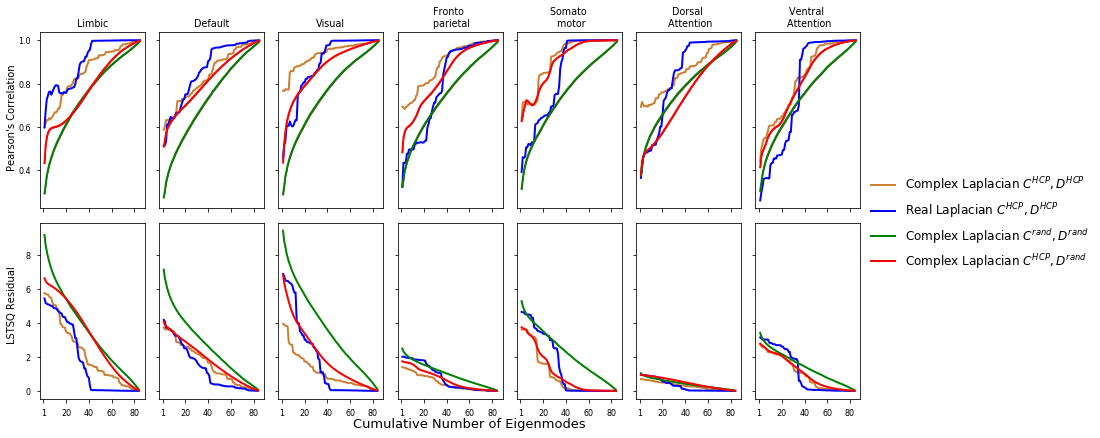

In [21]:
# add-onto the plot above:
with plt.style.context("seaborn-paper"):
    corr_fig, corr_ax = plt.subplots(2, 7, figsize=(12, 6), sharey="row", sharex=True)
    for i, ax in enumerate(corr_ax.reshape(-1)):
        if i <= 6:
            ax.plot(
                np.arange(1, 86),
                complex_pearsonr[:, i],
                color=(0.8, 0.5, 0.2),
                linewidth=LW,
            )
            ax.plot(np.arange(1, 86), real_pearsonr[:, i], color="blue", linewidth=LW)
            ax.plot(np.arange(1, 86), pearsonr_mean[i, :], color="green", linewidth=LW)
            ax.fill_between(
                np.arange(1, 86),
                lower_pr[i, :],
                upper_pr[i, :],
                color="maroon",
                alpha=0.8,
            )
            ax.plot(np.arange(1, 86), distance_pmean[i, :], color="red", linewidth=LW)
            ax.fill_between(
                np.arange(1, 86),
                lower_dpr[i, :],
                upper_dpr[i, :],
                color="maroon",
                alpha=0.8,
            )
            ax.title.set_text(fc_names[i])
        if i > 6:
            ax.plot(
                np.arange(1, 85),
                complex_residuals[:, i - 7],
                color=(0.8, 0.5, 0.2),
                linewidth=LW,
            )
            ax.plot(
                np.arange(1, 85), real_residual[:, i - 7], color="blue", linewidth=LW
            )
            ax.plot(
                np.arange(1, 85), residual_mean[i - 7, :], color="green", linewidth=LW
            )
            ax.fill_between(
                np.arange(1, 85),
                lower_drr[i - 7, :],
                upper_drr[i - 7, :],
                color="maroon",
                alpha=0.1,
            )
            ax.plot(
                np.arange(1, 85), distance_rmean[i - 7, :], color="red", linewidth=LW
            )
            ax.fill_between(
                np.arange(1, 85),
                lower_drr[i - 7, :],
                upper_drr[i - 7, :],
                color="maroon",
                alpha=0.1,
            )
            ax.xaxis.set_major_locator(plt.MultipleLocator(20))
            ax.set_xticklabels([0, 1, 20, 40, 60, 80])

    plt.tight_layout()
    corr_fig.text(0.00, 0.60, "Pearson's Correlation", fontsize=10, rotation="vertical")
    corr_fig.text(0.00, 0.20, "LSTSQ Residual", fontsize=10, rotation="vertical")
    corr_fig.text(0.40, 0.00, "Cumulative Number of Eigenmodes", fontsize=13)
    plt.legend(
        [
            r"Complex Laplacian $C^{HCP}, D^{HCP}$",
            r"Real Laplacian $C^{HCP}, D^{HCP}$",
            r"Complex Laplacian $C^{rand}, D^{rand}$",
            r"Complex Laplacian $C^{HCP}, D^{rand}$",
        ],
        loc="center left",
        bbox_to_anchor=(1, 1),
        fontsize="large",
        frameon=False,
    )

Create inset plot with zoomed-in view of the first few eigenmodes:

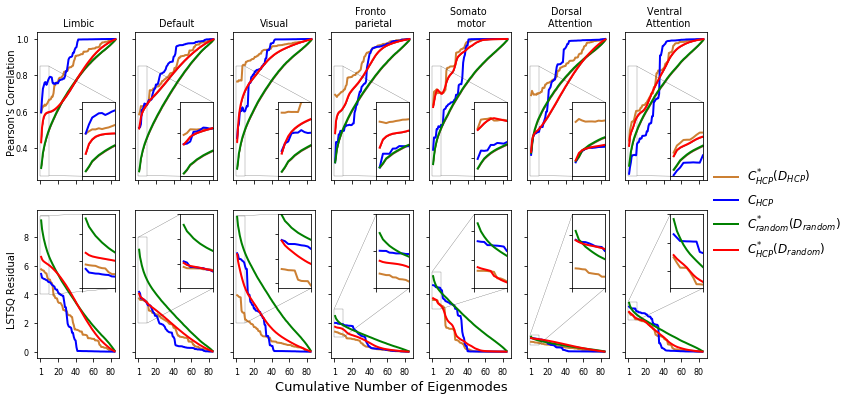

In [22]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

px1, px2, py1, py2 = 0, 10, 0.25, 0.85
rbound = np.array(
    [
        0,
        10,
        4,
        9.5,
        0,
        10,
        2,
        8,
        0,
        10,
        2,
        9.5,
        0,
        10,
        1,
        3,
        0,
        10,
        3,
        5.6,
        0,
        10,
        0.5,
        1.2,
        0,
        10,
        2.2,
        3.5,
    ]
).reshape(7, 4)

# add-onto the plot above:
with plt.style.context("seaborn-paper"):
    corr_fig, corr_ax = plt.subplots(2, 7, figsize=(12, 6), sharey="row", sharex=True)
    for i, ax in enumerate(corr_ax.reshape(-1)):
        if i <= 6:
            ax.plot(
                np.arange(1, 86),
                complex_pearsonr[:, i],
                color=(0.8, 0.5, 0.2),
                linewidth=LW,
            )
            ax.plot(np.arange(1, 86), real_pearsonr[:, i], color="blue", linewidth=LW)
            ax.plot(np.arange(1, 86), pearsonr_mean[i, :], color="green", linewidth=LW)
            ax.fill_between(
                np.arange(1, 86),
                lower_pr[i, :],
                upper_pr[i, :],
                color="maroon",
                alpha=0.8,
            )
            ax.plot(np.arange(1, 86), distance_pmean[i, :], color="red", linewidth=LW)
            ax.fill_between(
                np.arange(1, 86),
                lower_dpr[i, :],
                upper_dpr[i, :],
                color="maroon",
                alpha=0.8,
            )
            # inset:
            axin = inset_axes(ax, width="40%", height="50%", loc=4)
            axin.plot(
                np.arange(1, 86),
                complex_pearsonr[:, i],
                color=(0.8, 0.5, 0.2),
                linewidth=LW,
            )
            axin.plot(np.arange(1, 86), real_pearsonr[:, i], color="blue", linewidth=LW)
            axin.plot(
                np.arange(1, 86), pearsonr_mean[i, :], color="green", linewidth=LW
            )
            axin.fill_between(
                np.arange(1, 86),
                lower_pr[i, :],
                upper_pr[i, :],
                color="maroon",
                alpha=0.8,
            )
            axin.plot(np.arange(1, 86), distance_pmean[i, :], color="red", linewidth=LW)
            axin.fill_between(
                np.arange(1, 86),
                lower_dpr[i, :],
                upper_dpr[i, :],
                color="maroon",
                alpha=0.8,
            )
            axin.set_xlim(px1, px2)
            axin.set_ylim(py1, py2)
            plt.yticks(visible=False)
            plt.xticks(visible=False)
            mark_inset(ax, axin, loc1=1, loc2=4, fc="none", ec="0.2")
            ax.title.set_text(fc_names[i])
        if i > 6:
            ax.plot(
                np.arange(1, 85),
                complex_residuals[:, i - 7],
                color=(0.8, 0.5, 0.2),
                linewidth=LW,
            )
            ax.plot(
                np.arange(1, 85), real_residual[:, i - 7], color="blue", linewidth=LW
            )
            ax.plot(
                np.arange(1, 85), residual_mean[i - 7, :], color="green", linewidth=LW
            )
            ax.fill_between(
                np.arange(1, 85),
                lower_drr[i - 7, :],
                upper_drr[i - 7, :],
                color="maroon",
                alpha=0.1,
            )
            ax.plot(
                np.arange(1, 85), distance_rmean[i - 7, :], color="red", linewidth=LW
            )
            ax.fill_between(
                np.arange(1, 85),
                lower_drr[i - 7, :],
                upper_drr[i - 7, :],
                color="maroon",
                alpha=0.1,
            )
            ax.set_xticklabels([0, 1, 20, 40, 60, 80])
            ax.xaxis.set_major_locator(plt.MultipleLocator(20))
            # inset:
            axin = inset_axes(ax, width="40%", height="50%", loc=1)
            axin.plot(
                np.arange(1, 85),
                complex_residuals[:, i - 7],
                color=(0.8, 0.5, 0.2),
                linewidth=LW,
            )
            axin.plot(
                np.arange(1, 85), real_residual[:, i - 7], color="blue", linewidth=LW
            )
            axin.plot(
                np.arange(1, 85), residual_mean[i - 7, :], color="green", linewidth=LW
            )
            axin.fill_between(
                np.arange(1, 85),
                lower_drr[i - 7, :],
                upper_drr[i - 7, :],
                color="maroon",
                alpha=0.1,
            )
            axin.plot(
                np.arange(1, 85), distance_rmean[i - 7, :], color="red", linewidth=LW
            )
            axin.fill_between(
                np.arange(1, 85),
                lower_drr[i - 7, :],
                upper_drr[i - 7, :],
                color="maroon",
                alpha=0.1,
            )
            axin.set_xlim(rbound[i - 7, 0], rbound[i - 7, 1])
            axin.set_ylim(rbound[i - 7, 2], rbound[i - 7, 3])
            plt.yticks(visible=False)
            plt.xticks(visible=False)
            mark_inset(ax, axin, loc1=2, loc2=4, fc="none", ec="0.2")

    # plt.tight_layout()
    corr_fig.text(0.09, 0.60, "Pearson's Correlation", fontsize=10, rotation="vertical")
    corr_fig.text(0.09, 0.20, "LSTSQ Residual", fontsize=10, rotation="vertical")
    corr_fig.text(0.40, 0.05, "Cumulative Number of Eigenmodes", fontsize=13)
    plt.legend(
        [
            r"$C^{*}_{HCP}(D_{HCP})$",
            r"$C_{HCP}$",
            r"$C^{*}_{random}(D_{random})$",
            r"$C^{*}_{HCP}(D_{random})$",
        ],
        loc="center left",
        bbox_to_anchor=(1, 1),
        fontsize="large",
        frameon=False,
    )
    plt.savefig("../figures/fig5/pearson_residual.png", dpi=300, bbox_inches="tight")

### 3. Compute p-values:
We want to compute the p-values for all combinations of comparisons, start with complex vs. all others with just the first (best performing) eigenmode:

In [23]:
def compute_pvalues(S, RCD):
    """
    This function maps the input S into a z-score according to the mean and standard deviation of RCD.
    Returns the p-value (one tailed) according to a normal distribution
    """
    zs = st.zmap(S, RCD)
    return st.norm.sf(abs(zs))

In [24]:
CRR = np.zeros(7)  # Complex C Vs. Random C (Random D)

N = 0
for i, keys in enumerate(rand_dist.keys()):
    if i & 1 == 1:
        CRR[N] = compute_pvalues(complex_pearsonr[0, N], rand_dist[keys][0, :])
        N += 1

In [25]:
from IPython.display import display, Latex

fc_names = [
    "Limbic",
    "Default",
    "Visual",
    "Frontoparietal",
    "Somatomotor",
    "Dorsal \nAttention",
    "Ventral \nAttention",
]
for i, name in enumerate(fc_names):
    txt = r"{0:^}: ${1:.2e}$"
    txt = txt.format(name, CRR[i])
    display(Latex(txt))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Repeat for real-valued C vs. Random C&D:

In [26]:
RRR = np.zeros(7)  # real C vs. Random C (Random D)

N = 0
for i, keys in enumerate(rand_dist.keys()):
    if i & 1 == 1:
        RRR[N] = compute_pvalues(real_pearsonr[0, N], rand_dist[keys][0, :])
        N += 1

for i, name in enumerate(fc_names):
    txt = r"{0:^}: ${1:.2e}$"
    txt = txt.format(name, RRR[i])
    display(Latex(txt))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Complex Vs. Complex C (Random D)

In [27]:
CCR = np.zeros(7)

N = 0
for i, keys in enumerate(D_dist.keys()):
    if (i&1 ==1):
        CCR[N] = compute_pvalues(complex_pearsonr[0,N], D_dist[keys][0,:])
        N += 1

for i, name in enumerate(fc_names):
    txt = r'{0:^}: ${1:.2e}$'
    txt = txt.format(name, CCR[i])
    display(Latex(txt))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Real Vs. Complex C(Random D):

In [28]:
RCR = np.zeros(7)

N = 0
for i, keys in enumerate(D_dist.keys()):
    if (i&1 ==1):
        RCR[N] = compute_pvalues(real_pearsonr[0,N], D_dist[keys][0,:])
        N += 1

for i, name in enumerate(fc_names):
    txt = r'{0:^}: ${1:.2e}$'
    txt = txt.format(name, RCR[i])
    display(Latex(txt))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Summarize in Pandas Dataframe table:

In [29]:
pvals = np.stack((CRR, RRR, CCR, RCR), axis=1)
fc_names = [
    "Limbic",
    "Default",
    "Visual",
    "Frontoparietal",
    "Somatomotor",
    "Dorsal Attention",
    "Ventral Attention",
]
pvals_df = pd.DataFrame(
    pvals,
    columns=[
        r"$C^{*}_{HCP}$ vs. $C^{*}_{random}(D_{random})$",
        r"$C_{HCP}$ vs. $C^{*}_{random}(D_{random})$",
        r"$C^{*}_{HCP}$ vs. $C^{*}_{HCP}(D_{random})$",
        r"$C_{HCP}$ vs. $C^{*}_{HCP}(D_{random})$",
    ],
    index=fc_names,
)

In [30]:
def highlight_sig(val):
    color = "red" if val < 0.05 else "black"
    return "color: %s" % color


pd.set_option("precision", 3)
pvals_df.style.set_precision(3).format("{:.3e}").applymap(highlight_sig)
# pvals_df.style.background_gradient(cmap=cm)

,$C^{*}_{HCP}$ vs. $C^{*}_{random}(D_{random})$,$C_{HCP}$ vs. $C^{*}_{random}(D_{random})$,$C^{*}_{HCP}$ vs. $C^{*}_{HCP}(D_{random})$,$C_{HCP}$ vs. $C^{*}_{HCP}(D_{random})$
Limbic,1.504e-06,1.466e-06,1.355e-03,1.328e-03
Default,2.015e-07,5.512e-05,1.119e-01,4.804e-01
Visual,1.122e-13,4.967e-03,9.580e-06,3.928e-01
Frontoparietal,2.263e-06,4.993e-01,2.856e-03,1.789e-02
Somatomotor,5.882e-06,1.459e-01,3.088e-01,9.173e-23
Dorsal Attention,2.412e-04,4.522e-01,6.038e-06,4.101e-01
Ventral Attention,2.700e-02,2.705e-01,6.175e-02,6.202e-16


### 4. Full complex Laplacian: 

Write a new function that looks at both the complex and real portions of the eigenmodes instead of `abs()` of the entire thing.

In [ ]:
full_residuals = np.zeros([84, 7]) # combinations of eigenmodes and 7 networks
full_pearsonr = np.zeros([85, 7]) # combinations of eigenmodes and 7 networks

for i in np.arange(0, len(fc_names)): 
    # for each of the 7 canonical networks:
    full_pearsonr[:,i], full_residuals[:,i] = compute_lstsq(
        fc_dk_normalized,
        a = parameters.iloc[i,0],
        wnk = parameters.iloc[i,1],
        fc_name = fc_dk_normalized.index[i],
        lap_type = 'full'
    )

In [ ]:
%matplotlib widget

In [ ]:
# add-onto the plot above:
with plt.style.context('seaborn-paper'):
    corr_fig, corr_ax = plt.subplots(2,7, figsize=(12,6), sharey='row', sharex=True)
    for i, ax in enumerate(corr_ax.reshape(-1)):
        if i <= 6:
            ax.plot(np.arange(1,86), complex_pearsonr[:,i], color=(0.8,0.5,0.2), linewidth=LW)
            ax.plot(np.arange(1,86), real_pearsonr[:,i], color='blue', linewidth=LW)
            ax.plot(np.arange(1,86), pearsonr_mean[i,:], color='green', linewidth=LW)
            ax.fill_between(
                np.arange(1,86), 
                lower_pr[i,:], 
                upper_pr[i,:],
                color='maroon', 
                alpha=0.8
            )
            ax.plot(np.arange(1,86), distance_pmean[i,:], color='red', linewidth=LW)
            ax.fill_between(
                np.arange(1,86),
                lower_dpr[i,:],
                upper_dpr[i,:],
                color='maroon',
                alpha=0.8
            )
            ax.plot(np.arange(1,86), full_pearsonr[:,i], color='black', linewidth=LW)
            ax.title.set_text(fc_names[i])
        if i > 6:
            ax.plot(np.arange(1,85), complex_residuals[:,i-7], color=(0.8,0.5,0.2), linewidth=LW)
            ax.plot(np.arange(1,85), real_residual[:,i-7], color='blue', linewidth=LW)
            ax.plot(np.arange(1,85), residual_mean[i-7,:], color='green', linewidth=LW)
            ax.fill_between(
                np.arange(1,85),
                lower_drr[i-7,:],
                upper_drr[i-7,:],
                color='maroon',
                alpha=0.1
            )
            ax.plot(np.arange(1,85), distance_rmean[i-7,:], color='red', linewidth=LW)
            ax.fill_between(
                np.arange(1,85),
                lower_drr[i-7,:],
                upper_drr[i-7,:],
                color='maroon',
                alpha=0.1
            )
            ax.plot(np.arange(1,85), full_residuals[:,i-7], color='black', linewidth=LW)
            ax.xaxis.set_major_locator(plt.MultipleLocator(20))
            ax.set_xticklabels([0, 1, 20, 40, 60, 80])
            
    plt.tight_layout()
    corr_fig.text(0.00, 0.60, "Pearson's Correlation", fontsize=10, rotation="vertical")
    corr_fig.text(0.00, 0.20, "LSTSQ Residual", fontsize=10, rotation="vertical")
    corr_fig.text(0.40, 0.00, "Cumulative Number of Eigenmodes", fontsize=13)
    plt.legend(['Complex Laplacian', 'Real Laplacian', 'Random','Distance', 'Fully Complex'], loc = 'center left', bbox_to_anchor = (1, 1))